In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from utils import import_dataset, get_scores, classes, label2id
import pandas as pd
from numpy import mean, std
from tqdm.notebook import tqdm
import time
from datasets import load_dataset
import pickle
CLASSES = classes

In [21]:
def collect_dataset(seed, save_vect=False):
    
    # returns preprocessed train, test and essays in history test set; trained vectorizer
    
    vectorizer = TfidfVectorizer(max_features=5000)
    
    # main dataset
    dataset = import_dataset(seed)
    
    y_train = dataset['train']['labels']
    y_test = dataset['test']['labels']
    
    x_train = vectorizer.fit_transform(dataset['train']['text'])
    x_test = vectorizer.transform(dataset['test']['text'])
    
    # essays in history
    eh_dataset = load_dataset('json', data_files='hume_json/essays_in_history.json')
    
    x_eh_test = vectorizer.transform(eh_dataset['train']['text'])
    y_eh_test = eh_dataset['train']['labels']
    
    if save_vect:
        with open('models/tfidf_vectorizer.pkl','wb') as f:
            pickle.dump(vectorizer, f)
    
    return x_train, y_train, x_test, y_test, x_eh_test, y_eh_test, vectorizer

In [3]:
def run_model(model, 
              title, 
              data=(),
              seed=13,
              matrix=True, 
              print_accuracy=True,
              collect_mistakes=False,
              test_eh=True):
    
    if not data:
        data = collect_dataset(seed)
    
    x_train, y_train, x_test, y_test, x_eh_test, y_eh_test, _ = data
    
    model.fit(x_train,y_train)
    pred = model.predict(x_test)
    eh_pred = model.predict(x_eh_test)

    if test_eh:
        eh_accuracy = get_scores(eh_pred, y_eh_test, title='essay-history', matrix=True, print_=False)
        print('Accuracy on essays in history: ', eh_accuracy)

    accuracy = get_scores(pred, y_test, title=title, matrix=matrix, print_=print_accuracy)
                
    out = {'accuracy':accuracy,
           'pred':pred}
                
                
    if collect_mistakes:
        mistakes = []
    
        for i in range(len(y_test)):
            t = y_test[i]
            p = pred[i]

            if t != p:
                mistakes.append((CLASSES[t], CLASSES[p], dataset['test'][i]['title'], dataset['test'][i]['text']))

        df = pd.DataFrame(mistakes, columns=['true', 'predicted', 'title', 'text'])
        out['mistakes'] = df
    
    return out

In [4]:
def run_many(model, iterations=15):
    accuracy_scores = []
    for seed in tqdm([i for i in range(iterations)]):
        acc = run_model(model, '_', seed=seed, matrix=False, print_accuracy=False, test_eh=False)['accuracy']
        accuracy_scores.append(acc)
        
    print('Mean accuracy: ', mean(accuracy_scores))
    print('Standard deviation for accuracy: ', std(accuracy_scores))

## Preparation

In [5]:
CLASSES

['dialogues',
 'dissertation',
 'enquiry',
 'essay',
 'history',
 'political discourses',
 'treatise']

In [6]:
data = collect_dataset(13)

# SVM

In [7]:
from sklearn.svm import SVC, LinearSVC

Accuracy on essays in history:  0.7164179104477612
Accuracy: 0.7741935483870968%
Training time: 0.12975406646728516 s


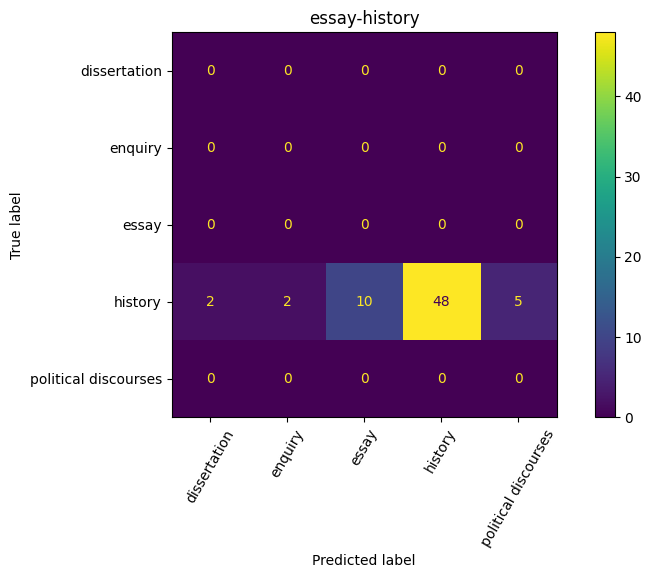

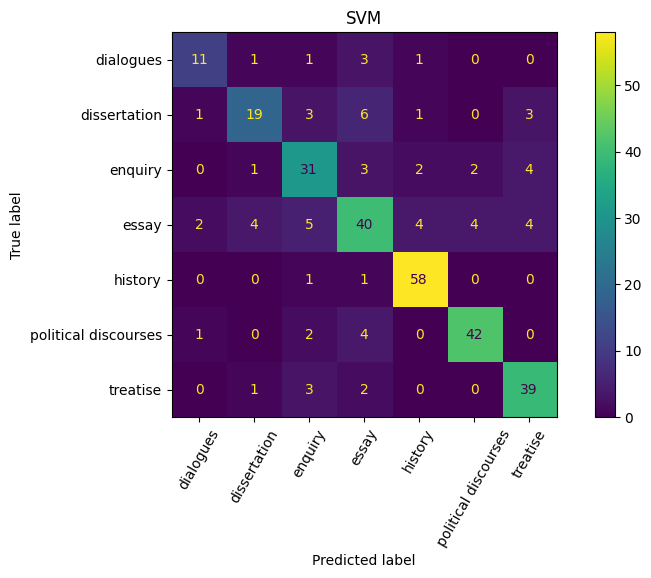

In [8]:
svm_model = LinearSVC()
start = time.time()
d = run_model(svm_model, 'SVM', data=data)
print(f'Training time: {time.time()-start} s')

In [ ]:
# it mostly mistakes essay-like things for essay-like things

In [ ]:
run_many(svm_model)

# Logistic Regression

In [9]:
from sklearn.linear_model import LogisticRegression

Accuracy on essays in history:  0.7164179104477612
Accuracy: 0.7516129032258064%
Training time: 2.7332494258880615 s


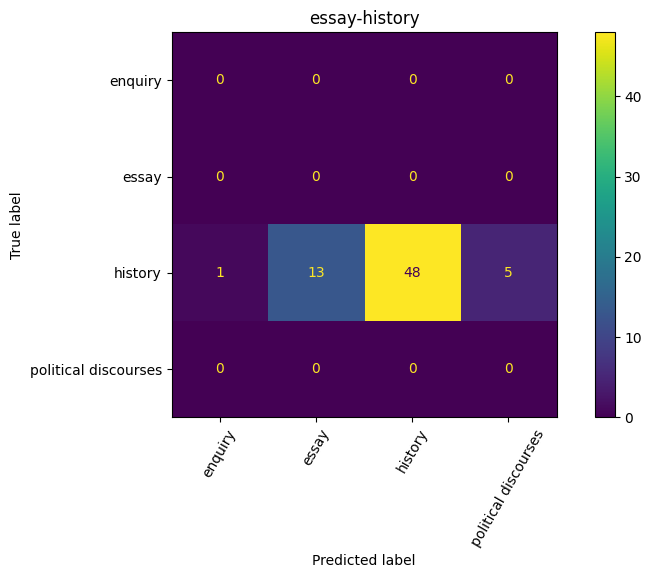

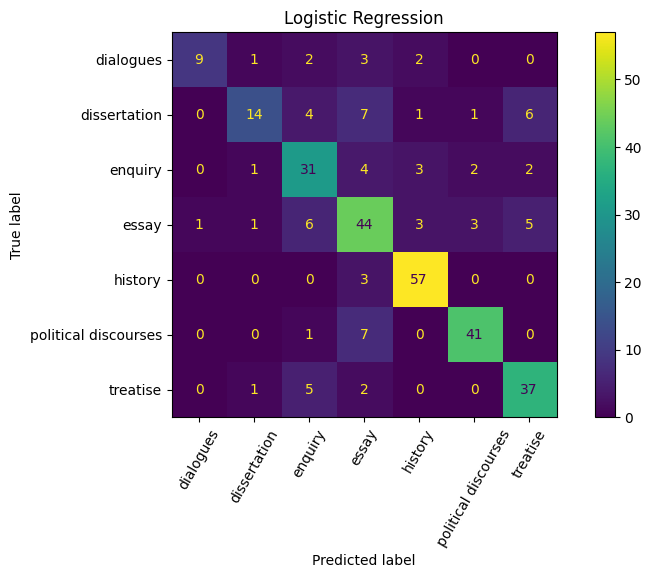

In [10]:
logreg_model = LogisticRegression()
start = time.time()
run_model(logreg_model, 'Logistic Regression')
print(f'Training time: {time.time()-start} s')

In [20]:
with open('models/logreg.pkl','wb') as f:
    pickle.dump(logreg_model, f)

In [ ]:
# save vectorizer
collect_dataset(13, save_vect=True)

In [ ]:
run_many(logreg_model, 15)

# Additional experiments

## Collecting mistakes

In [ ]:
svm_mistakes = run_model(svm_model, 
                         'SVM', 
                         matrix=False, 
                         collect_mistakes=True, 
                         print_accuracy=False)['mistakes']

In [ ]:
logreg_mistakes = run_model(logreg_model, 
                            'Logreg', 
                            matrix=False, 
                            collect_mistakes=True, 
                            print_accuracy=False)['mistakes']

In [ ]:
mistakes_merged = logreg_mistakes.merge(svm_mistakes, how='outer')

In [ ]:
mistakes_merged.to_csv('mistakes.csv', index=False)

## Extracting features

In [11]:
x_train, y_train, x_test, y_test, x_eh_test, y_eh_test, vect = collect_dataset(13)
feature_names = list(vect.get_feature_names_out())
feature_names[1000:1010]

['contemplate',
 'contemplation',
 'contempt',
 'contemptible',
 'content',
 'contented',
 'contest',
 'contests',
 'contiguity',
 'contiguous']

In [12]:
def feature_extraction(model, genre, feature_names=[], n=20):
    
    if not feature_names:
        _, _, _, _, _, _, vect = collect_dataset(13)
        feature_names = list(vect.get_feature_names_out())
    
    ind = label2id[genre]
    
    zips = [(name, coef) for name, coef in zip(feature_names, model.coef_[ind])]
    
    print(f'{genre} | negative')

    for word in sorted(zips, key = lambda pair: pair[1])[:n]:
        print(word[0])

    print()

    print(f'{genre} | positive')

    for word in sorted(zips, key = lambda pair: pair[1], reverse=True)[:n]:
        print(word[0])

In [15]:
feature_extraction(svm_model, 'treatise', feature_names=feature_names)

treatise | negative
between
seems
farther
sentiment
public
people
or
similar
was
great
accomplishments
could
sorrow
ever
should
former
affection
you
so
moral

treatise | positive
betwixt
impressions
viz
action
perfectly
same
that
possession
evident
quality
either
this
certain
identity
idea
produce
considerable
my
must
since


In [21]:
feature_extraction(logreg_model, 'treatise', feature_names=feature_names)

treatise | negative
was
between
you
he
were
the
so
people
all
ever
great
sentiment
had
public
could
much
farther
life
seems
man

treatise | positive
we
idea
betwixt
impressions
that
is
same
ideas
objects
this
it
action
imagination
any
my
viz
relation
evident
produce
certain


## Extracting logits / probabilities

In [28]:
# LinearSVC does not have probablities 
# SVC does, but it does not allow to look into features

pred1 = svm_model.predict(x_eh_test)
# pred2 = svm_model.predict_log_proba(x_eh_test)
# pred3 = svm_model.predict_proba(x_eh_test)

In [13]:
logreg_proba = logreg_model.predict_proba(x_eh_test) # 67 x 7

In [14]:
sure = 0
unsure = 0

for line in logreg_proba:
    
    line = list(line)
    m = max(line) # first max
    ind = line.index(m)
    line.pop(ind)
    
    m2 = max(line) # second max
    ind2 = line.index(m2)
#     print(m, ind, m2, ind2)
    
    if m2 > 0.15: # if second max is more than treshold, the model is not super sure, and it is curious
        unsure += 1
    else:
        sure += 1

        
print(f'Sure: {sure}, unsure: {unsure}')

Sure: 16, unsure: 51


# Other models

## Gradient boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
gb_model = GradientBoostingClassifier()
start = time.time()
run_model(gb_model, 'Gradient Boost')
print(f'Training time: {time.time()-start} s')

## Decision tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
dt_model = DecisionTreeClassifier()
start = time.time()
run_model(dt_model, 'Decision Tree')
print(f'Training time: {time.time()-start} s')

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
forest_model = RandomForestClassifier(n_estimators=10)
start = time.time()
run_model(forest_model, 'Random Forest')
print(f'Training time: {time.time()-start} s')